This script builds a neural net to forecast isoprene and optimises hyper parameters using Bayesian optimisation. The best model is then further optimised to ensure it finds the bottom of a local minima.

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from bayes_opt import BayesianOptimization


# making sure the random seeds work for all libraries (this might be overkill)
random.seed(9)
np.random.seed(9)
torch.manual_seed(9)
torch.cuda.manual_seed_all(9)

In [61]:
data = pd.read_csv(r'/Users/gabegreenberg/Documents/UW/ds_785_capstone/data/historical_data.csv')
# removing columns with less than 5% corrilation with isoprene or one of the 95% or greater colinear variables 
data = data.drop(columns=['wsp', 'no_drought', 'precipitation (mm)', 'mfpar'])
print(data)

                      time  isoprene  previous_week_avg  51_week_avg  \
0      2021-01-23 01:00:00  0.004636           0.013394     0.022043   
1      2021-01-23 02:00:00  0.004636           0.013394     0.022043   
2      2021-01-23 03:00:00  0.004636           0.013394     0.022043   
3      2021-01-23 04:00:00  0.004636           0.013394     0.022043   
4      2021-01-23 05:00:00  0.004636           0.013394     0.022043   
...                    ...       ...                ...          ...   
27718  2024-12-30 20:00:00  0.005008           0.013522     0.007293   
27719  2024-12-30 21:00:00  0.005008           0.013522     0.007293   
27720  2024-12-30 22:00:00  0.005008           0.013522     0.007293   
27721  2024-12-30 23:00:00  0.005008           0.013522     0.007293   
27722  2024-12-31 00:00:00  0.005008           0.013522     0.007293   

       24_hour_isoprene     temp_f       nox        solr       relh  \
0              0.004636  29.215617  3.406550    0.000000  72.631

In [62]:
# setting up my train, validation, and test sets
validation_split_date = "2023-01-01"
test_split_date = "2024-01-01"

train = data[data["time"] < validation_split_date] 
validation = data[(data["time"] >= validation_split_date) & (data["time"] < test_split_date)]
test = data[data["time"] >= test_split_date]  

X_train = train.drop(columns=["time", "isoprene"])  
y_train = train["isoprene"]

X_validation = validation.drop(columns=["time", "isoprene"])
y_validation = validation["isoprene"]

X_test = test.drop(columns=["time", "isoprene"])
y_test = test["isoprene"]

# standardising the scale of variables so that they are all wighted the same
# I referenced this documentation: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scalerX = StandardScaler()
scalerY = StandardScaler()

X_train_sc = scalerX.fit_transform(X_train)
X_validation_sc = scalerX.transform(X_validation)
X_test_sc = scalerX.transform(X_test)

y_train_sc = scalerY.fit_transform(y_train.values.reshape(-1, 1))
y_validation_sc = scalerY.transform(y_validation.values.reshape(-1, 1))
y_test_sc = scalerY.transform(y_test.values.reshape(-1, 1))

# convert test, validation, and training sets into tensor format (https://pytorch.org/docs/stable/tensors.html)
X_train_ts= torch.tensor(X_train_sc, dtype=torch.float32)
y_train_ts = torch.tensor(y_train_sc, dtype=torch.float32)

X_validation_ts = torch.tensor(X_validation_sc, dtype=torch.float32)
y_validation_ts = torch.tensor(y_validation_sc, dtype=torch.float32)

X_test_ts = torch.tensor(X_test_sc, dtype=torch.float32)
y_test_ts = torch.tensor(y_test_sc, dtype=torch.float32)


In [63]:
# here I build and run a nn I referenced documentation from https://pytorch.org/docs/stable/nn.html such as https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential.append to help me. 
# I try to add refernces in the scrip but in general I looked through a lot of the pytorch documentation working on this
class IsoNN(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, dropout):
        """
        Defining the NN model using flexible paramters and layers such that these parameters can be tuned

        Args:
            input_dim: number of predictors
            hidden_size: number of neurons in each hidden layer
            num_layers: number of hidden layers
            dropout: likleyhood of any neuron being excluded during training forward step
        
        Methods:
            forward:
                passes the data into the model and returns the prediction for evaluation
        """
        super(IsoNN, self).__init__()
        sublayers_lst = []
        # this loop stores layers dynimicaly based on the number of layers (num_layers) and the size of hidden layers passed in which can be tunned 
        for ii in range(num_layers): 
        
            if ii == 0:
                in_dims = input_dim 
            else:
                in_dims = hidden_size

            sublayers_lst.append(nn.Linear(in_dims, hidden_size))
            sublayers_lst.append(nn.ReLU())
            sublayers_lst.append(nn.Dropout(dropout))

        sublayers_lst.append(nn.Linear(hidden_size, 1)) 
        self.model = nn.Sequential(*sublayers_lst)

    def forward(self, x):
        return self.model(x)


def isonn_evaluation_func(hidden_size, num_layers, dropout, learning_rate):
    """
    This function converts the data into tensors that pytourch can use, runs the NN defined in the class abouve and evaluates it via RMSE

    Args:
        hidden_size: number of nodes in each hidden layer
        num_layers: number of hidden layers
        dropout: likleyhood of any neuron being excluded during training forward step
        learning_rate: the learning rate of the optimiser
    
    Returns:
        the rmse for evaluating the model such that hyper parameter tuning can be conducted.
    """
    hidden_size = int(hidden_size)
    num_layers = int(num_layers)

    # this initilizes the an instance of the model, the cost function and the optimizer
    # I referenced https://pytorch.org/docs/stable/optim.html
    nn_model = IsoNN(input_dim=X_train.shape[1], hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    cost = nn.MSELoss()
    optimizer = optim.SGD(nn_model.parameters(), lr=learning_rate)
   
    #this loop trains the model (I refernced this when working on it https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) plus other general pytourch documentation
    itters = 50 
    for itter in range(itters):
        nn_model.train()
        optimizer.zero_grad()
        y_pred = nn_model(X_train_ts)
        loss = cost(y_pred, y_train_ts)
        loss.backward()
        optimizer.step()

    nn_model.eval()
    with torch.no_grad():
        y_pred_validation = nn_model(X_validation_ts).numpy()

    #reset the scale back to normal since earler I scaled everything
    y_pred_validation_rescaled = scalerY.inverse_transform(y_pred_validation)
    y_validation_rescaled = scalerY.inverse_transform(y_validation_ts.numpy())

    rmse = np.sqrt(mean_squared_error(y_validation_rescaled, y_pred_validation_rescaled))

    return -rmse  

param_options = {
    "num_layers": (1, 4),   
    "hidden_size": (8, 300),               
    "dropout": (0.1, 0.6),          
    "learning_rate": (0.0001, 0.015) 
}

# here I am apply Bayesian optimization using the isonn_evaluation_func function abouve as my objective function (I am optimising on my validation set)
# I referenced this documentiation when setting up bayesianoptimization https://pypi.org/project/bayesian-optimization/
bays_optimizer = BayesianOptimization(
    f=isonn_evaluation_func, 
    pbounds=param_options, 
    random_state=8,
    verbose=2  
)

bays_optimizer.maximize(init_points=6, n_iter=15)

|   iter    |  target   |  dropout  | hidden... | learni... | num_la... |
-------------------------------------------------------------------------
| 1         | -0.09932  | 0.5367    | 290.8     | 0.01305   | 2.593     |
| 2         | -0.1097   | 0.2164    | 11.33     | 0.006514  | 2.207     |
| 3         | -0.1025   | 0.3613    | 147.7     | 0.008375  | 2.63      |
| 4         | -0.1016   | 0.4804    | 216.0     | 0.009333  | 2.278     |
| 5         | -0.09913  | 0.2445    | 292.4     | 0.005073  | 1.656     |
| 6         | -0.1002   | 0.1329    | 295.0     | 0.002005  | 1.966     |
| 7         | -0.09284  | 0.3305    | 271.4     | 0.01485   | 1.088     |
| 8         | -0.09926  | 0.1239    | 259.3     | 0.003951  | 1.284     |
| 9         | -0.09582  | 0.1689    | 277.6     | 0.01335   | 1.192     |
| 10        | -0.1123   | 0.4758    | 82.96     | 0.005522  | 3.928     |
| 11        | -0.106    | 0.2333    | 183.9     | 0.01468   | 3.988     |
| 12        | -0.1036   | 0.5484    | 

In [64]:
#getting the best parameters from bayesian optimization
best_params = bays_optimizer.max['params']
hidden_size = int(best_params['hidden_size'])
num_layers = int(best_params['num_layers'])
dropout = best_params['dropout']
learning_rate = best_params['learning_rate']

# setting up the model with the best parameters from the bayesian optimization step then using stacastic gradient decent to do the final optimization step 
# I referenced https://pytorch.org/docs/stable/optim.html
best_m = IsoNN(input_dim=X_train.shape[1], hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
optimizer = optim.SGD(best_m.parameters(), lr=learning_rate)
cost = nn.MSELoss()
num_itters = 1000 

# this loop does the final optimization step to make sure I find the bottom of the local minima found during hyper paramiter tuning
for itter in range(num_itters):
    best_m.train()
    optimizer.zero_grad()
    y_pred = best_m(X_train_ts)
    loss = cost(y_pred, y_train_ts)
    loss.backward()
    optimizer.step()
    
# here I predict the test set using the best model for honest assesment of the model
with torch.no_grad():
    best_m.eval()
    y_pred_test = best_m(X_test_ts).numpy()


# undo the scaling so that it can be assesed properly in (ppb)
y_pred_test_rescaled = scalerY.inverse_transform(y_pred_test)
y_test_rescaled = scalerY.inverse_transform(y_test_sc)

final_rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_test_rescaled))
print(f"Final RMSE: {final_rmse:.4f}")


Final RMSE: 0.1032


In [65]:
print("Best Hyperparamiters:")
print(f"Number of Layers: {num_layers}")
print(f"Hiden Size: {hidden_size}")
print(f"Dropout: {dropout}")
print(f"Learning Rate: {learning_rate}")
print(best_m.model)

Best Hyperparamiters:
Number of Layers: 1
Hiden Size: 271
Dropout: 0.33053592407687415
Learning Rate: 0.01484919180639112
Sequential(
  (0): Linear(in_features=15, out_features=271, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.33053592407687415, inplace=False)
  (3): Linear(in_features=271, out_features=1, bias=True)
)


/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_79626/3767496855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['time'] = pd.to_datetime(test["time"])


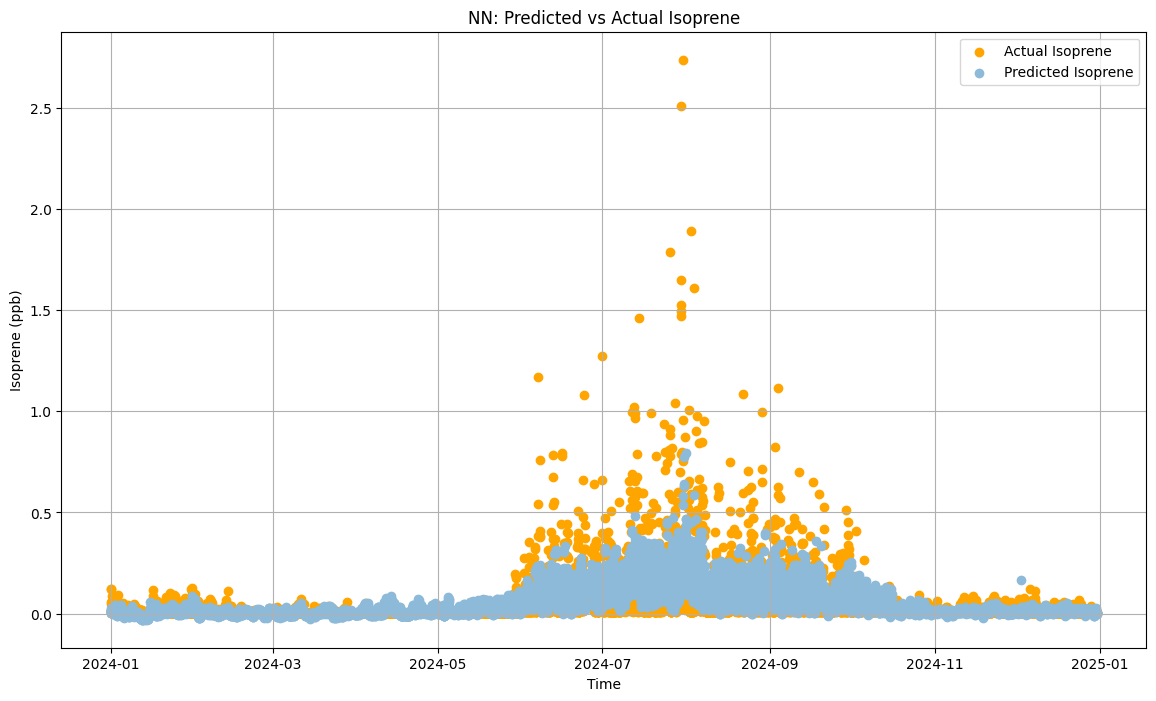

In [66]:
test['time'] = pd.to_datetime(test["time"])

plt.figure(figsize=(14, 8))
plt.scatter(test['time'], y_test_rescaled, label="Actual Isoprene", color="orange")
plt.scatter(test['time'], y_pred_test_rescaled, label="Predicted Isoprene", color="#8ebad9")
plt.xlabel("Time")
plt.ylabel("Isoprene (ppb)")
plt.title("NN: Predicted vs Actual Isoprene")
plt.grid()
plt.legend()
plt.show()

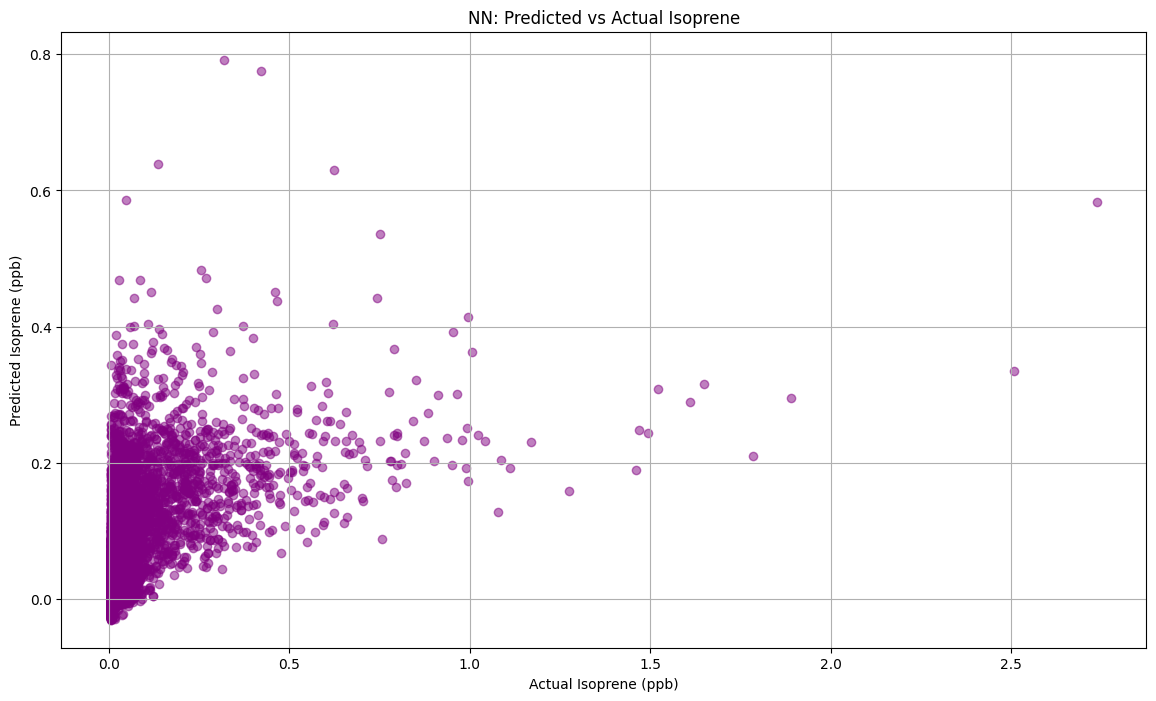

In [67]:
plt.figure(figsize=(14, 8))
plt.scatter(y_test_rescaled, y_pred_test_rescaled, label="Actual", color="purple", alpha=.5)
plt.xlabel("Actual Isoprene (ppb)")
plt.ylabel("Predicted Isoprene (ppb)")
plt.title("NN: Predicted vs Actual Isoprene")
plt.grid()
plt.show()

In [68]:
print(len(test))
print(len(y_test_rescaled))

out_df = test.copy()
out_df = out_df[['time']]
out_df['isoprene'] = y_test_rescaled.flatten()
out_df['pred'] = y_pred_test_rescaled.flatten()
print(out_df)

# saving the results from the model on the test set for comparison with the other models
out_df.to_csv(r'/Users/gabegreenberg/Documents/UW/ds_785_capstone/data_out/NN_out.csv', index=False)

8210
8210
                     time  isoprene      pred
19513 2024-01-01 00:00:00  0.005157  0.010549
19514 2024-01-01 01:00:00  0.005157  0.009586
19515 2024-01-01 02:00:00  0.013180  0.014828
19516 2024-01-01 03:00:00  0.017840  0.026284
19517 2024-01-01 04:00:00  0.049260  0.014160
...                   ...       ...       ...
27718 2024-12-30 20:00:00  0.005008  0.000212
27719 2024-12-30 21:00:00  0.005008 -0.000896
27720 2024-12-30 22:00:00  0.005008  0.001698
27721 2024-12-30 23:00:00  0.005008  0.007078
27722 2024-12-31 00:00:00  0.005008  0.003250

[8210 rows x 3 columns]
